In [187]:
import sys

sys.path.append("../functions")

from Utils import *
from Plotting import *
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
# from sklearn.linear_model import LinearRegression
# import seaborn as sns
import warnings
import seaborn
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats
from scipy.special import logsumexp
from itertools import product
from functools import partial
from multiprocessing import Pool


In [365]:
raw_data = pd.read_csv("../data/twoArmedandit_with_confidence.csv")
data = raw_data[["sub", "condition", "cresp", "resp", "cj","cor", "phase", "trial", "trial_rev","reward", "Lreward", "Hreward" ]]
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]

# selecting portion of data with proper task
lv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subjects))
]
subjects = lv_induction_data["sub"].unique()

In [384]:
## def logll
def get_states_prob_hsmm(dist_params, log_emmission_prob_seq, T, durations):
    
    D = len(durations)
    
    dist = scipy.stats.nbinom(*dist_params)
    transition_log = dist.logpmf(durations)
    transition_log = transition_log - logsumexp(transition_log)
    log_alpha = np.full((T+1, 2), -np.inf)
    log_alpha[0,:] = 1
    log_alpha[0,:] = log_alpha[0,:] - logsumexp(log_alpha[0,:])

    state_k_prob = np.zeros((T,2, D))

    for t, time in enumerate(range(1,T+1)):
        temp_d = np.zeros((2,D))
        for k, current_time in enumerate(durations):
            if current_time == 1:
                k_emmission_prob = 0
                d_emmission_prob = log_emmission_prob_seq[t,:, k]
            elif time - current_time <0 :
                k_emmission_prob = -np.inf
                d_emmission_prob = -np.inf
            else:
                k_emmission_prob = log_emmission_prob_seq[t-1,:, k-1]
                d_emmission_prob = log_emmission_prob_seq[t,:,k]

            state_k_prob[t,:,k] = k_emmission_prob + np.flip(log_alpha[time-current_time,:])
            temp_d[:,k] = d_emmission_prob + transition_log[k] + np.flip(log_alpha[time-current_time,:])
        log_alpha[time,:] = logsumexp(temp_d, axis=-1)

    state_log_probs = logsumexp(state_k_prob, axis = -1)
    sum_probs = logsumexp(state_log_probs, axis=1, keepdims=True)
    state_log_probs = state_log_probs - sum_probs
    state_probs = np.exp(state_log_probs)
    return state_probs

def sub_state_prob_hsmm(sub_id, data):
  
    sub_data = data[data["sub"] == subjects[sub_id]]
    T = len(sub_data)
    rewards = sub_data["reward"].to_numpy()*100
    actions = sub_data["resp"].to_numpy()

    log_emmision_prob = np.zeros((T, 2)) # T = 1 to 400
    high_reward_dist = scipy.stats.norm(60, 8)
    low_reward_dist = scipy.stats.norm(40, 8)

    log_emmision_prob[:,0] = low_reward_dist.logpdf(rewards) # low_reward
    log_emmision_prob[:,1] = high_reward_dist.logpdf(rewards) # high_reward


    durations = range(1,71)
    D = len(durations)


    log_emmission_prob_seq = np.zeros((T,2,D)) # time from t=1 to T(400), states,durations = (1,40),

    for t, time in enumerate(range(1,T+1)):
            for d, duration in enumerate(durations):
                if t-d < 0:
                    log_emmission_prob_seq[t,:,d] = -np.inf
                else:
                    log_emmission_prob_seq[t,0,d] = np.sum(log_emmision_prob[time-duration:time,1][actions[time-duration:time] == 0]) + \
                                                    np.sum(log_emmision_prob[time-duration:time,0][actions[time-duration:time] == 1])

                    log_emmission_prob_seq[t,1,d] = np.sum(log_emmision_prob[time-duration:time,0][actions[time-duration:time] == 0]) + \
                                        np.sum(log_emmision_prob[time-duration:time,1][actions[time-duration:time] == 1])
    
    p_range = np.linspace(0.01, 0.99, 16)  
    n_range = np.linspace(0.01, 100, 16)
    grid = list(product(n_range, p_range))
    
    func = partial(get_states_prob_hsmm, log_emmission_prob_seq= log_emmission_prob_seq, T = T, durations = durations)

    with Pool(128) as pool:
        results = pool.map(func, grid)

    return grid,results

In [385]:
def protected_log(x):
    return np.log((1e-200 / 2) + (1 - 1e-200) * x)

def calculate_mf_probs(params, resps, rewards):
    alpha, beta = params[:2]
    Q = np.array([0.5, 0.5])
    probabilities = np.zeros(len(resps))
    for t, (resp, reward) in enumerate(zip(resps, rewards)):
        choice_prob = softmax_func(Q, beta)
        probabilities[t] = choice_prob[resp]
        Q[resp] += alpha * (reward - Q[resp])
    return probabilities



def ll_mix_model(params, resps, rewards, mb_probs):
    gamma, alpha, beta = params
    
    mf_probs = calculate_mf_probs((alpha,beta), resps, rewards)
    mix_probs = gamma*mf_probs + (1-gamma)*mb_probs
    
    return -np.sum(protected_log(mix_probs))

def fit_n_times(n_fitting, params_ranges, func, func_args):
    results = [minimize(func, x0=[np.random.uniform(*r) for r in params_ranges], args=func_args, bounds=params_ranges) for _ in range(n_fitting)]
    best_result = min(results, key=lambda x: x.fun if x.success else np.inf)
    return best_result.x, best_result.fun



def process_fit(args):
    i, results, actions, rewards, T = args
    states_prob_hsmm = results[i]
    mb_probs = states_prob_hsmm[np.arange(T), actions]
    x, ll = fit_n_times(20, params_ranges=[[0,1],[0.01, 1], [0.01, 100]],
                         func=ll_mix_model, func_args=(actions, rewards, mb_probs))
    return ll, x

def get_ll_model(sub_id, data): 
    sub_data = data[data["sub"] == subjects[sub_id]]
    rewards = sub_data["reward"].to_numpy()
    actions = sub_data["resp"].to_numpy()
    T = len(actions)
    grid, results = sub_state_prob_hsmm(sub_id, data)
    
    args_list = [(i, results, actions, rewards, T) for i in range(len(results))]
    
    with Pool(60) as pool:
        results_parallel = pool.map(process_fit, args_list)
    
    neg_ll_seq, params = zip(*results_parallel)
    
    min_idx = np.argmin(neg_ll_seq)
    neg_ll = neg_ll_seq[min_idx]
    mf_x = params[min_idx]
    mb_x = grid[min_idx]
    
    return neg_ll, mf_x, mb_x


In [124]:
# Assuming `subjects` is defined somewhere in your code
results = []
for sub_id, subject in enumerate(subjects):
    print(sub_id)
    neg_ll, mf_x, mb_x = get_ll_model(sub_id, data)
    gamma, alpha, beta = mf_x
    n, p = mb_x
    
    results.append({
        "subject": subject,
        "neg_ll": neg_ll,
        "gamma": gamma,
        "alpha": alpha,
        "beta": beta,
        "n": n,
        "p": p
    })

df = pd.DataFrame(results)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


In [125]:
df.to_csv("../results/forward_mix_df_2.csv", index=False)

In [257]:
mf_df = pd.read_csv("../results/forward_df.csv")
mb_df = pd.read_csv("../results/")

array([  0.17916891,   0.69830555, 100.        ])

In [127]:
res[np.arange(T), actions].shape

NameError: name 'T' is not defined

In [128]:
mb_res = []
T = 400
for sub_id, subject in enumerate(subjects):
    print("sub_id", sub_id)
    grid, results = sub_state_prob_hsmm(sub_id)
    
    sub_data = lv_induction_data[lv_induction_data["sub"] == subjects[sub_id]]
    rewards = sub_data["reward"].to_numpy()
    actions = sub_data["resp"].to_numpy()
    
    neg_ll_seq = []
    for res in results:
        probs = res[np.arange(T), actions]
        neg_ll_seq.append(-np.sum(protected_log(probs)))
    
    min_idx = np.argmin(neg_ll_seq)
    
    neg_ll = neg_ll_seq[min_idx]
    mb_x = grid[min_idx]

    n, p = mb_x
    
    mb_res.append({
        "subject": subject,
        "neg_ll": neg_ll,
        "n": n,
        "p": p
    })

mb_df = pd.DataFrame(mb_res)



sub_id 0
sub_id 1
sub_id 2
sub_id 3
sub_id 4
sub_id 5
sub_id 6
sub_id 7
sub_id 8
sub_id 9
sub_id 10
sub_id 11
sub_id 12
sub_id 13
sub_id 14
sub_id 15
sub_id 16
sub_id 17
sub_id 18
sub_id 19
sub_id 20
sub_id 21
sub_id 22
sub_id 23
sub_id 24
sub_id 25
sub_id 26
sub_id 27
sub_id 28
sub_id 29
sub_id 30
sub_id 31
sub_id 32
sub_id 33
sub_id 34
sub_id 35
sub_id 36
sub_id 37
sub_id 38
sub_id 39
sub_id 40
sub_id 41
sub_id 42
sub_id 43
sub_id 44
sub_id 45
sub_id 46
sub_id 47
sub_id 48
sub_id 49
sub_id 50
sub_id 51
sub_id 52
sub_id 53


In [133]:
mb_df.to_csv("../results/mb_forward_2.csv", index=False)

Statistics for mf and mb =260.0, p=3.261e-05
Statistics for mb and mix =5.0, p=2.153e-10
Statistics for mf and mix =700.0, p=7.144e-01
mean mf = 232.22
mean mb = 303.42
mean mix = 213.22


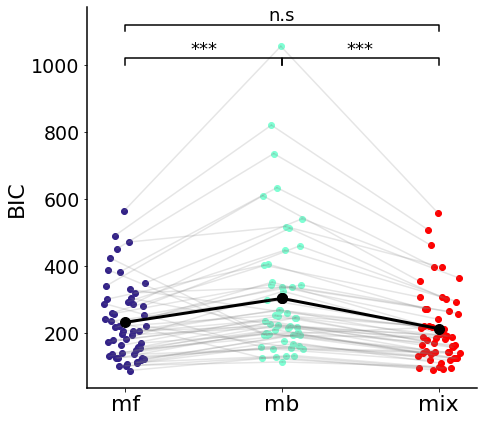

In [362]:
from Utils import *
from Plotting import *

mf_df = pd.read_csv("../results/forward_df.csv")
mf_df["bic"] = 2*mf_df["LL"] + 2*np.log(400)
mb_df = pd.read_csv("../results/mb_forward_2.csv")
mb_df["bic"] = 2*mb_df["neg_ll"] + 2*np.log(400)
mix_df = pd.read_csv("../results/forward_mix_df_2.csv")
mix_df["bic"] = 2*mix_df["neg_ll"] + 5*np.log(400)

groups = ["mf", "mb", "mix"]
merged_df = merge_result_df([mf_df, mb_df, mix_df], groups, 200, subjects)



color_dict = {"mb": "#7FFFD4", "mf": "#332288", "mix": "red"}

plt.figure(figsize=(7,7))
comparison_plot(
    merged_df,
    "bic",
    groups,
    "",
    [["mf", "mb"], ["mb", "mix"], ["mf", "mix"]],
    [1000, 1000, 1100],
    [20, 20, 20],
    y_label="BIC",
    color_dict = color_dict
)

In [252]:
np.log(400)

5.991464547107982

Statistics for mf and mix =93.0, p=2.240e-08
Statistics for mix and mb =1.0, p=1.720e-10
Statistics for mf and mb =260.0, p=3.261e-05
mean mf = 224.23
mean mix = 193.26
mean mb = 295.44


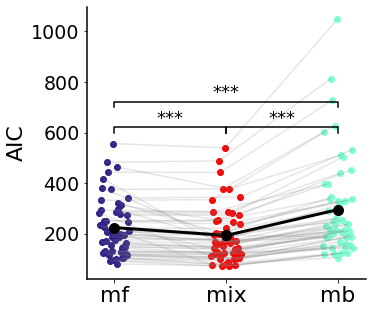

In [417]:
from Utils import *
from Plotting import *

mf_df = pd.read_csv("../results/forward_df.csv")
mf_df["bic"] = 2*mf_df["LL"] + 2*np.log(400)
mf_df["aic"] = 2*mf_df["LL"] +2*2
mf_df["neg_ll"] = mf_df["LL"]

mb_df = pd.read_csv("../results/mb_forward_2.csv")
mb_df["bic"] = 2*mb_df["neg_ll"] + 2*np.log(400)
mb_df["aic"] = 2*mb_df["neg_ll"] + 2*2

mix_df = pd.read_csv("../results/forward_mix_df_2.csv")
mix_df["bic"] = 2*mix_df["neg_ll"] + 5*np.log(400)
mix_df["aic"] = 2*mix_df["neg_ll"] + 5*2

groups = ["mf","mix", "mb"]
merged_df = merge_result_df([mf_df, mix_df, mb_df], groups, 200, subjects)
# merged_df = merged_df.merge(df_best_model[["subject", "model"]].rename(columns={"model": "best_model"}), on ="subject")
# merged_df = merged_df[merged_df["best_model"] == "mf"]



color_dict = {"mb": "#7FFFD4", "mf": "#332288", "mix": "red"}

plt.figure(figsize=(5,5))
comparison_plot(
    merged_df,
    "aic",
    groups,
    "",
    [["mf", "mix"], ["mix", "mb"], ["mf", "mb"]],
    [600, 600, 700],
    [20, 20, 20],
    y_label="AIC",
    color_dict = color_dict
)

In [418]:
merged_df

,Unnamed: 0,subject,alpha,beta,lbound,bound_range,LL,Confidence Distance,hbound,bic,aic,neg_ll,model,x_idx,gamma,n,p
0,0.0,45628,1.000000,11.609160,4.605658,0.227874,137.997922,0.774465,4.695518,287.978774,279.995845,137.997922,mf,1,NaN,NaN,NaN
1,1.0,45640,0.712177,16.827743,4.462571,0.071960,114.860509,0.418840,4.501244,241.703948,233.721019,114.860509,mf,2,NaN,NaN,NaN
2,2.0,45664,1.000000,9.946770,3.148277,0.000000,164.286110,1.549730,3.148277,340.555150,332.572221,164.286110,mf,3,NaN,NaN,NaN
3,3.0,45682,1.000000,10.014854,1.488940,0.821554,144.475233,0.728441,4.373464,300.933394,292.950465,144.475233,mf,4,NaN,NaN,NaN
4,4.0,45745,1.000000,9.672207,4.092176,0.945758,188.692218,0.437737,4.950758,389.367364,381.384435,188.692218,mf,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,NaN,47431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,460.063469,452.080540,224.040270,mb,450,NaN,6.676,0.402000
158,NaN,47470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,195.774077,187.791148,91.895574,mb,451,NaN,0.010,0.206000
159,NaN,47737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,343.535808,335.552879,165.776440,mb,452,NaN,6.676,0.467333
160,NaN,47740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,540.907012,532.924083,264.462041,mb,453,NaN,6.676,0.402000


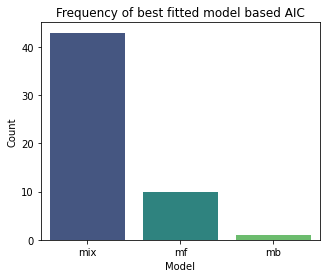

In [420]:
df_best_model = merged_df.loc[merged_df.groupby('subject')['aic'].idxmin()]
# Count the occurrences of each model
plt.figure(figsize=(5, 4))
sns.countplot(data=df_best_model, x="model", palette="viridis")

# Labels and title
plt.xlabel("Model")
plt.ylabel("Count")
plt.title("Frequency of best fitted model based AIC")

# Show the plot
plt.show()

In [412]:
df_best_model

,Unnamed: 0,subject,alpha,beta,lbound,bound_range,LL,Confidence Distance,hbound,bic,aic,neg_ll,model,x_idx,gamma,n,p
54,NaN,45628,1.000000,72.048720,NaN,NaN,NaN,NaN,NaN,131.367546,111.410223,50.705112,mix,201,0.000000,93.334,0.794000
55,NaN,45640,0.709754,100.000000,NaN,NaN,NaN,NaN,NaN,96.543406,76.586083,33.293042,mix,202,0.028682,93.334,0.794000
2,2.0,45664,1.000000,9.946770,3.148277,0.000000,164.286110,1.549730,3.148277,340.555150,332.572221,164.286110,mf,3,NaN,NaN,NaN
3,3.0,45682,1.000000,10.014854,1.488940,0.821554,144.475233,0.728441,4.373464,300.933394,292.950465,144.475233,mf,4,NaN,NaN,NaN
112,NaN,45745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,195.205485,187.222556,91.611278,mb,405,NaN,86.668,0.794000
59,NaN,45760,0.289640,100.000000,NaN,NaN,NaN,NaN,NaN,163.878730,143.921408,66.960704,mix,206,0.063912,13.342,0.467333
6,6.0,45763,1.000000,16.674608,2.498130,0.881425,59.649345,0.963744,4.703341,131.281618,123.298689,59.649345,mf,7,NaN,NaN,NaN
61,NaN,45805,1.000000,72.039025,NaN,NaN,NaN,NaN,NaN,187.688820,167.731497,78.865749,mix,208,0.000000,86.668,0.794000
62,NaN,45829,1.000000,9.124666,NaN,NaN,NaN,NaN,NaN,221.377559,201.420237,95.710118,mix,209,0.220831,80.002,0.794000
9,9.0,45964,0.866118,12.043129,1.579689,0.823172,123.916290,0.823909,4.395193,259.815509,251.832580,123.916290,mf,10,NaN,NaN,NaN


In [413]:
sub_data = lv_induction_data[lv_induction_data["sub"]  == subjects[0]] 
sub_data

,sub,condition,cresp,resp,cj,cor,phase,trial,trial_rev,reward,Lreward,Hreward


<AxesSubplot:xlabel='gamma', ylabel='Count'>

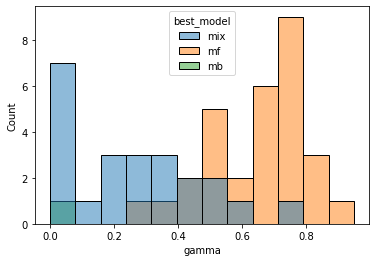

In [414]:
plt.Figure(figsize=(10,10))
mix_df_modified = mix_df.merge(df_best_model[["subject", "model"]].rename(columns={"model": "best_model"}), on ="subject")
# mix_df_modified = mix_df_modified[mix_df_modified["best_model"] == "mf"]

sns.histplot(mix_df_modified, x="gamma", hue="best_model", bins=12)

plt.show()

In [39]:
def simulate_mix_model(sub_data, params):
    
    alph,beta, gamma, n,p = params
    
    lrewards =  sub_data["Lreward"].to_numpy()
    hrewards = sub_data["Hreward"].to_numpy()
    cresps = sub_data["cresp"].to_numpy()
    
    
    T = len(cresps)
    
    # mf
    Q = np.array([0.5, 0.5])
    Q_list = np.zeros((T, 2))
    rewards = np.zeros(T)
    actions = np.zeros(T)
    chosen_probs = np.zeros(T)
    
    #mb
    durations = range(1,71)
    D = len(durations)
    
    dist = scipy.stats.nbinom(n,p)
    transition_log = dist.logpmf(durations)
    transition_log = transition_log - logsumexp(transition_log)
    log_alpha = np.full((T+1, 2), -np.inf)
    log_alpha[0,:] = 1
    log_alpha[0,:] = log_alpha[0,:] - logsumexp(log_alpha[0,:])
    log_emmision_prob = np.zeros((T, 2)) # T = 1 to 400
    high_reward_dist = scipy.stats.norm(60, 8)
    low_reward_dist = scipy.stats.norm(40, 8)
    state_k_prob = np.zeros((T,2, D))
    log_emmission_prob_seq = np.zeros((T,2,D)) # time from t=1 to T(400), states,durations = (1,40),

    

    acc = np.zeros(T)
    
    for t,time in enumerate(range(1,T+1)):
        #mf
        low_reward = lrewards[t]
        high_reward = hrewards[t]
        
        mf_probs = softmax_func(Q, beta) #mf prob
        
        #mb
        for k, current_time in enumerate(durations):
            if current_time == 1:
                k_emmission_prob = 0
            elif time - current_time <0 :
                k_emmission_prob = -np.inf
            else:
                k_emmission_prob = log_emmission_prob_seq[t-1,:, k-1]
            state_k_prob[t,:,k] = k_emmission_prob + np.flip(log_alpha[time-current_time,:])
            
        current_log_state = logsumexp(state_k_prob[t], axis = -1)
        current_log_state -= logsumexp(current_log_state, axis=-1)
        mb_probs = np.exp(current_log_state)
        
        # action 
        mix_probs = gamma*mf_probs + (1-gamma)*mb_probs
        resp = np.random.choice([0, 1], p=mix_probs)        
        
        if resp == cresps[t]:
            reward = hrewards[t]
            acc[t] = 1
        else:
            acc[t] = 0
            reward = lrewards[t]
        actions[t]= resp
        rewards[t]= reward
        
        #mf update
        prediction_error = reward/100 - Q[resp]
        Q[resp] = Q[resp] + alpha * prediction_error
        
        #mb update
        log_emmision_prob[t,0] = low_reward_dist.logpdf(reward)
        log_emmision_prob[t,1] = high_reward_dist.logpdf(reward)

        temp_d = np.zeros((2,D))
        for d, duration in enumerate(durations):
            if time - duration <0 :
                log_emmission_prob_seq[t,:,d] = -np.inf
                d_emmission_prob = -np.inf
            else:
                log_emmission_prob_seq[t,0,d] = np.sum(log_emmision_prob[time-duration:time,1][actions[time-duration:time] == 0]) + \
                                                np.sum(log_emmision_prob[time-duration:time,0][actions[time-duration:time] == 1])
                log_emmission_prob_seq[t,1,d] = np.sum(log_emmision_prob[time-duration:time,0][actions[time-duration:time] == 0]) + \
                                    np.sum(log_emmision_prob[time-duration:time,1][actions[time-duration:time] == 1])

                d_emmission_prob = log_emmission_prob_seq[t,:,d]
            temp_d[:,d] = d_emmission_prob + transition_log[d] + np.flip(log_alpha[time-duration,:])
        log_alpha[time,:] = logsumexp(temp_d, axis=-1)

#     confs = linear_transform_on_array(chosen_probs, [0, 1], [lbound, hbound])
    return acc

    
    
    

In [138]:
mix_df = pd.read_csv("../results/forward_mix_df_2.csv")


In [79]:
sub_id = 6
sub_data = lv_induction_data[lv_induction_data["sub"] == subjects[sub_id]]
params = mix_df[mix_df["subject"] == subjects[sub_id]].iloc[0][["alpha","beta", "gamma", "n", "p"]]
acc = simulate_mix_model(sub_data, params)

In [301]:
def run_simulation(sub_id):
    """Function to run 120 simulations and compute the average ACC."""
    sub_data = lv_induction_data[lv_induction_data["sub"] == subjects[sub_id]]
    params = mix_df[mix_df["subject"] == subjects[sub_id]].iloc[0][["alpha","beta", "gamma", "n", "p"]]
    
    acc_values = [np.mean(simulate_mix_model(sub_data, params)) for _ in range(100)]
    avg_acc = np.mean(acc_values)
    
    return subjects[sub_id], avg_acc

num_subjects = len(subjects)  # Assuming subjects is a list

with Pool(processes=60) as pool:
    results = pool.map(run_simulation, range(num_subjects))

# Convert results into a DataFrame for better visualization
results_df = pd.DataFrame(results, columns=["Subject", "performance"])


In [104]:
forward_sim = pd.read_csv("../results/forward_simulation_df.csv")

In [280]:
forward_avg = forward_sim.groupby(["subject","run"]).mean("cor").reset_index()
forward_avg= forward_avg.groupby("subject").mean("cor").reset_index()[["subject","cor"]].rename(columns={"cor": "performance"})


In [303]:
mix_sim = results_df
mix_sim = mix_sim.rename(columns={"Subject": "subject"})

forward_avg = forward_sim.groupby(["subject","run"]).mean("cor").reset_index()
forward_avg= forward_avg.groupby("subject")["cor"].mean().reset_index()[["subject","cor"]].rename(columns={"cor": "performance"})

emp_avg = lv_induction_data.groupby("sub").mean("cor").reset_index()[["sub","cor"]] \
                                                      .rename(columns={"cor": "performance","sub":"subject"})



paired
Statistics for emp and mf =7.0, p=3.539e-08
Statistics for mix and emp =164.0, p=1.642e-01
Statistics for mix and mf =0.0, p=1.863e-09
mean mf = 0.77
mean emp = 0.84
mean mix = 0.83


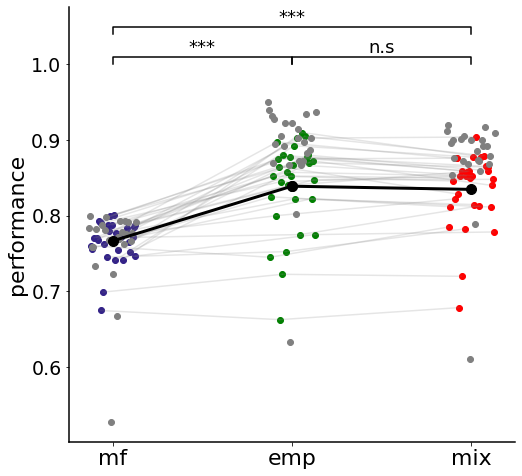

In [415]:
groups = ["mf", "emp","mix"]
merged_df = merge_result_df([forward_avg, emp_avg, mix_sim], groups, 200, subjects)
merged_df = merged_df.merge(df_best_model[["subject", "model"]].rename(columns={"model": "best_model"}), on ="subject")
filtered_df = merged_df[merged_df["best_model"] == "mf"]
# filtered_df = merged_df

color_dict = {"emp": "green", "mf": "#332288", "mix": "red"}

plt.figure(figsize=(8,8))
plt.title("paired test")
print("paired")
comparison_plot(
    filtered_df,
    "performance",
    groups,
    "",
    [["emp", "mf"], ["mix", "emp"], ["mix", "mf"]],
    [1, 1, 1.04],
    [.01, .01, .01],
    y_label="performance",
    color_dict = color_dict
)

df = merged_df[merged_df["best_model"] != "mf"]
for gr in ["mf", "emp", "mix"]:
    plt.scatter(df.query("model=='{}'".format(gr)).x_idx,
                df.query("model=='{}'".format(gr))["performance"],
                label=gr, c="grey",
               alpha= 1)


In [395]:
mix_sim.to_csv("../results/mix_simulation_df.csv", index=False)

In [243]:
a = merged_df[merged_df["model"] == "emp"]["performance"].to_numpy() -  merged_df[merged_df["model"] == "mf"]["performance"].to_numpy()

a.argmax()

21

In [245]:
merged_df[merged_df["model"] == "emp"].iloc[21]

subject        46792
performance     0.91
model            emp
x_idx            239
best_model        mf
Name: 115, dtype: object

In [246]:
merged_df[merged_df["model"] == "mf"].iloc[21]

subject           46792
performance    0.741925
model                mf
x_idx                39
best_model           mf
Name: 114, dtype: object

non-paired test
Statistics for mf and emp =297.0, p=9.963e-13
Statistics for emp and mix =1697.0, p=1.428e-01
Statistics for mix and mf =2695.0, p=3.016e-14
mean mf = 0.76
mean emp = 0.86
mean mix = 0.85


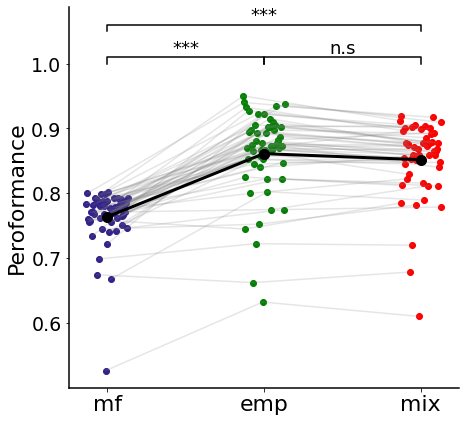

In [186]:
groups = ["mf", "emp", "mix"]
merged_df = merge_result_df([forward_avg, emp_avg, mix_sim], groups, 200, subjects)



color_dict = {"emp": "green", "mf": "#332288", "mix": "red"}

plt.figure(figsize=(7,7))
print("non-paired test")

comparison_plot(
    merged_df,
    "performance",
    groups,
    "",
    [["mf", "emp"], ["emp", "mix"], ["mix", "mf"]],
    [1, 1, 1.05],
    [.01, .01, .01],
    y_label="Peroformance",
    color_dict = color_dict
)

In [93]:
emp_avg = lv_induction_data.groupby("sub").mean("cor").reset_index()[["sub","cor"]] \
                                                      .rename(columns={"cor": "performacne","sub":"subject"})


<AxesSubplot:xlabel='performance', ylabel='Count'>

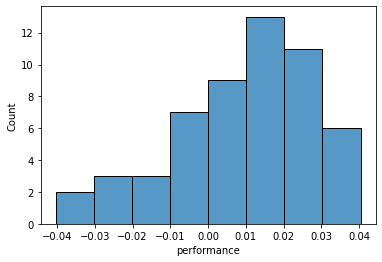

In [176]:

sns.histplot(emp_avg["performance"] - mix_sim["performance"])

In [185]:
color_dict = {"Backward": "#882255", "Forward": "#332288", "Empirical": "#117733"}
def comparison_plot(df, y_column, groups, titlestr="", s=[], y_list=[], h_list=[], legend="", y_label="",
                        var_df=pd.DataFrame(), color_dict = color_dict):
    

    for gr1, gr2 in zip(groups[:-1], groups[1:]):
        X_coords = np.array([df.query("model=='{}'".format(gr1)).x_idx,
                             df.query("model=='{}'".format(gr2)).x_idx])
        Y_coords = np.array([df.query("model=='{}'".format(gr1))[y_column],
                             df.query("model=='{}'".format(gr2))[y_column]])
        plt.plot(X_coords,
                 Y_coords,
                 color='gray',
                 alpha=.2)

        x_means = [df.query("model=='{}'".format(gr1)).x_idx.mean(), df.query("model=='{}'".format(gr2)).x_idx.mean()]
        y_means = [df.query("model=='{}'".format(gr1))[y_column].mean(),
                   df.query("model=='{}'".format(gr2))[y_column].mean()]
        plt.plot(x_means,
                 y_means,
                 marker='o',
                 linewidth=3, markersize=10, color="black")

    c = 0
    for gr1, gr2 in s:
        gr1_data = df.query("model=='{}'".format(gr1))
        gr2_data = df.query("model=='{}'".format(gr2))
        gr1_x_mean = gr1_data.x_idx.mean()
        gr2_x_mean = gr2_data.x_idx.mean()

        # stat, p = scipy.stats.ttest_ind(np.array(gr1_data[y_column]),np.array(gr2_data[y_column])).pvalue
        stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))
        print('Statistics for {} and {} ={}, p={:.3e}'.format(gr1, gr2,stat, p))
        symb = pval_symb(p)
        y = y_list[c]
        h = h_list[c]
        plt.plot([gr1_x_mean, gr1_x_mean, gr2_x_mean, gr2_x_mean], [y, y + h, y + h, y], lw=1.5, c="k")
        plt.text((gr1_x_mean + gr2_x_mean) / 2, y + h, symb, ha='center', va='bottom', fontsize=18)
        c += 1

    gr_xticks_ls = []
    for gr in groups:
        plt.scatter(df.query("model=='{}'".format(gr)).x_idx,
                    df.query("model=='{}'".format(gr))[y_column],
                    label=gr, c=color_dict[gr])
        gr_mean = df.query("model=='{}'".format(gr)).x_idx.mean()
        print("mean {} = {:.2f}".format(gr, df.query("model=='{}'".format(gr))[y_column].mean()))
        gr_xticks_ls.append(gr_mean)

    if not var_df.empty:
        for i, row in var_df.iterrows():
            line_pos = df[(df['subject'] == row["sub"]) & (df['model'] == "Low-Meta")]["x_idx"].iloc[0]
            line_mean = df[(df['subject'] == row["sub"]) & (df['model'] == "Low-Meta")][y_column].iloc[0]
            y_min = line_mean - row["cor"]
            y_max = line_mean + row["cor"]
            plt.vlines(x=line_pos, ymin=y_min, ymax=y_max, colors="#fc5252", alpha=.2)
            plt.hlines(y=y_min, xmin=line_pos - 1, xmax=line_pos + 1, colors="#fc5252", alpha=.2)
            plt.hlines(y=y_max, xmin=line_pos - 1, xmax=line_pos + 1, colors="#fc5252", alpha=.2)

    plt.title(titlestr, fontsize=12)
    plt.ylabel(y_label, fontsize=22)
    plt.yticks(fontsize=19)
    plt.xticks(fontsize=22)
    ax = plt.gca()
    plt.xticks(gr_xticks_ls, groups)

    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)

    # hide x-axis
    # ax.get_xaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)

(p = 8.31e-08, r = -0.65,ci = [-0.78,-0.47])


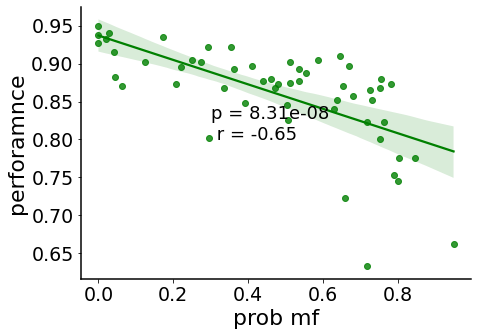

In [171]:
plt.figure(figsize=(7,5))
temp_df = emp_avg.merge(mix_df, on="subject")
temp_df2 = mix_sim.merge(mix_df, on="subject")
plot_regression_df(temp_df,"gamma", "performance", "green", .3, .8, "prob mf", "perforamnce")
# plot_regression_df(temp_df2,"gamma", "performance", "red", .3, .8, "prob mf", "perforamnce")

In [382]:
hv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "lc1")
    & (~data["sub"].isin(chance_level_subjects))
]

subjects = hv_induction_data["sub"].unique()

In [386]:
# Assuming `subjects` is defined somewhere in your code
results = []
for sub_id, subject in enumerate(subjects):
    print(sub_id)
    neg_ll, mf_x, mb_x = get_ll_model(sub_id, hv_induction_data)
    gamma, alpha, beta = mf_x
    n, p = mb_x
    
    results.append({
        "subject": subject,
        "neg_ll": neg_ll,
        "gamma": gamma,
        "alpha": alpha,
        "beta": beta,
        "n": n,
        "p": p
    })

hv_df = pd.DataFrame(results)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


<AxesSubplot:xlabel='gamma', ylabel='Count'>

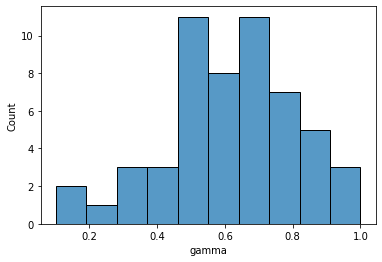

In [391]:
sns.histplot(hv_df,x="gamma",bins=10)

In [393]:
hv_df.gamma.mean()

0.6150339402661135

In [388]:
forward_sim.to_csv("../results/forward_simulation_df.csv", index=False)

In [392]:
hv_df.to_csv()

,subject,neg_ll,gamma,alpha,beta,n,p
0,45628,209.517235,0.539099,1.000000,2.407207,93.334,0.794000
1,45640,102.769585,0.574394,1.000000,18.265293,6.676,0.532667
2,45664,111.565747,0.841353,1.000000,11.274811,40.006,0.010000
3,45682,198.290154,0.524630,1.000000,3.522215,6.676,0.467333
4,45745,122.284363,0.108137,0.010000,0.010000,80.002,0.728667
5,45760,82.063799,0.649214,1.000000,16.060957,6.676,0.206000
6,45763,125.406064,0.411078,1.000000,8.065750,86.668,0.794000
7,45805,167.857873,0.246286,1.000000,1.350505,100.000,0.794000
8,45829,99.963789,0.494393,0.690644,12.838446,73.336,0.728667
9,45964,99.096588,0.718381,0.945124,14.712452,6.676,0.271333
